In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import boxcox
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore")


# Set up matplotlib for inline plotting
%matplotlib inline


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
c:\Users\oussa\miniconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#Upload our data 
df=pd.read_csv("main_data.csv")

## Project: Classification by TaxRate
Every day, KillBills handles countless receipts. My goal is to sort this data into groups or create a system that can predict what category an item belongs to. I plan to do this by looking at the tax rate for each item. This means I will need to change the 'taxRate' column in the data to show different categories based on the tax percentage. We'll use a clear rule to do this:

- Tax Rate between 0% and 6%:`` Low Tax Rate``
- Tax Rate from 6% up to 12%: ``Medium Tax Rate``
- Tax Rate over 12%: ``High Tax Rate``
- Tax Rate of 0%: ``No tax``


**We are going to follow this process:**
- Perform exploratory data analysis (EDA) and address any missing data.
- Conduct data cleansing and identification of missing values.
- Carry out an examination of the tax rate data to uncover patterns.
- Prepare the data for model training and testing.
- Opt for the most appropriate predictive model.

In [3]:
df.head()

,id,amount,description,date,itemName,parent,quantity,taxAmount,taxDescription,type,storeId,createdAt,updatedAt,taxRate
0,95622ac5-f517-4394-9691-830c1d72d4d7,0.00,NaN,NaN,goodbye california - medium,NaN,NaN,0.00,TVA 0 %,NaN,f2eb401d-585d-410f-aff9-e35f67ee9e2d,2023-04-05 17:36:33.471000+00:00,2023-04-05 17:36:33.471000+00:00,0
1,97418c24-8c15-4055-9259-c8af699c68fe,13.95,NaN,NaN,formule boeuf 🥙🍟🥤,NaN,NaN,1.17,TVA 0 %,menu,897a3d79-b358-4a76-b9bb-f72c857a5565,2023-04-05 17:36:34.006000+00:00,2023-04-05 17:36:34.006000+00:00,0
2,401d801d-6aa0-4eda-b387-6c739b3da293,8.60,NaN,NaN,pita boeuf,NaN,NaN,0.78,TVA 10 %,NaN,897a3d79-b358-4a76-b9bb-f72c857a5565,2023-04-05 17:36:34.011000+00:00,2023-04-05 17:36:34.011000+00:00,1000
3,68a5b978-0547-4af9-9829-5417a8c76c7b,3.02,NaN,NaN,frites 🍟,NaN,NaN,0.27,TVA 10 %,NaN,897a3d79-b358-4a76-b9bb-f72c857a5565,2023-04-05 17:36:34.011000+00:00,2023-04-05 17:36:34.011000+00:00,1000
4,3633ca34-5beb-42a8-a410-b1dd545f80d8,2.33,NaN,NaN,coca cherry 33cl,NaN,NaN,0.12,TVA 5.5 %,NaN,897a3d79-b358-4a76-b9bb-f72c857a5565,2023-04-05 17:36:34.011000+00:00,2023-04-05 17:36:34.011000+00:00,550


## **Data Exploration:**

### **``Handling Missing values:``**

In [4]:
print(f"Number of rows: {df.shape[0]}.\n")
print(f"Number of columns: {df.shape[1]}.\n")
print(f"Columns: {df.columns.values}\n")
print(f'Data type:\n {df.dtypes}')


Number of rows: 3142890.

Number of columns: 14.

Columns: ['id' 'amount' 'description' 'date' 'itemName' 'parent' 'quantity'
 'taxAmount' 'taxDescription' 'type' 'storeId' 'createdAt' 'updatedAt'
 'taxRate']

Data type:
 id                 object
amount            float64
description        object
date              float64
itemName           object
parent            float64
quantity          float64
taxAmount         float64
taxDescription     object
type               object
storeId            object
createdAt          object
updatedAt          object
taxRate             int64
dtype: object


In [5]:
# Count the number of missing values in each column
missing_values = df.isnull().sum()
print(f"Missing values:\n{missing_values}")

Missing values:
id                      0
amount                  0
description       2901154
date              3142890
itemName               28
parent            3142890
quantity          3142890
taxAmount               0
taxDescription          0
type              2999220
storeId                 0
createdAt               0
updatedAt               0
taxRate                 0
dtype: int64


To efficiently manage the missing values, cleanse the data, and enhance its comprehensibility, we propose the following steps::

- Discard the **parent**, **quantity**, and **date** columns, as they are empty.
- Remove the **updatedAt** column as it is a deplucate of the **createdAt** column.
- Dismiss the **taxDescription** column as it merely duplicates the information presented in the **TaxRate** column.
- The **Description** column containing 92.3% missing values, it's prudent to exclude this column.
- Convert the **id** from its existing ``UUID`` format to a more straightforward integer format (1, 2, 3, etc.).
- Similarly, alter the **storeId** from the ``UUID`` format to an integer format.
- Construct a new **taxRateClass** column to house the previously defined Tax Rate Classes.
- Delete any rows that have a missing **itemName** to preserve data integrity.
- Split the **createdAt** into different columns for easier use: day_of_month, day_of_week, and hour.

#### Are the columns `date`, `parent`, `quantity` columns empty?

In [6]:
# It  Looks like the 'date', 'parent', and 'quantity' columns are empty. 
# So, we're just going to get rid of these columns.
b_date = "YES" if df["date"].isnull().sum()==df.shape[0] else "No"
b_parent = "YES" if df["parent"].isnull().sum()==df.shape[0] else "No"
b_quantity = "YES" if df["quantity"].isnull().sum()==df.shape[0] else "No"
print(f"Is the 'date' column empty?: {b_date}")
print(f"Is the 'parent' column empty?: {b_parent}")
print(f"Is the 'quantity' column empty?: {b_quantity}")

Is the 'date' column empty?: YES
Is the 'parent' column empty?: YES
Is the 'quantity' column empty?: YES


In [7]:
# deleteing the `date`, `parent`, `quantity` columns.
df=df.drop(['date', 'parent', 'quantity'], axis=1)

#### Is `updatedAt` column a duplicate of the `createdAt`?

In [8]:
# I did observe that the 'CreatedAt' et 'UpdatedAt' are duplicates and we can see it thanks to:
df['createdAt'] = pd.to_datetime(df['createdAt'])
df['updatedAt'] = pd.to_datetime(df['updatedAt'])
b_duplicated= 'Yes' if (df['createdAt']==df['updatedAt']).sum() == df.shape[0] else 'No'
print(f'Is `updatedAt` column a duplicate of the `createdAt? : {b_duplicated}')

Is `updatedAt` column a duplicate of the `createdAt? : Yes


In [9]:
## Hence, we can simply drop the 'updatedAt' column which is not needed
df=df.drop(['updatedAt'], axis=1)

#### Does the ``taxDescription`` column  duplicates the information presented in the ``TaxRate`` column ?

From initial observation, it appears that when the `taxRate` is set to 550, the corresponding `taxDescription` is **"TVA 5.5 %"**. Moreover, when the `taxRate` is equal to 0, the `taxDescription` can take one of two possible values: **"TVA 0 %"** or **"noTaxDescription"**. Let's investigate further to confirm whether these assumptions hold true.


In [10]:
#The function help will take as a value a string and execute a transformation
#the value in the taxDescription column is "TVA n %" or "noTaxDescription"
#the function will return the taxDescription transformed (n*100 or 0 if the value is "noTaxDescription" )
def help(ss):
    if ss[0]=='T':
        # The \d+ pattern means "one or more digits"
        numbers = re.findall(r"[-+]?\d*\.\d+|[-+]?\d+", ss)

        # The result is a list of strings, so convert to int if needed:
        return float(numbers[0])*100
    return 0
df['transformed_taxDescription'] = df['taxDescription'].apply(help)
#We see if obtained a duplicate of the taxRate column using this tarnsformation
#Spoiler Alert: we did
b_taxD= 'Yes' if (df['transformed_taxDescription']==df['taxRate']).sum() == df.shape[0] else 'No'
print(f"Does the ``taxDescription`` column  duplicates the information presented in the ``TaxRate`` column ?: {b_taxD} ")


Does the ``taxDescription`` column  duplicates the information presented in the ``TaxRate`` column ?: Yes 


In [11]:
## Hence, we can simply drop the 'updatedAt' column which is not needed
df=df.drop(['taxDescription', "transformed_taxDescription"], axis=1)

#### What is the percentage of missing values in the `description` column?

In [12]:
print(f"the percentage of missing values in the `description` column: {round(df['description'].isnull().sum()/df.shape[0]*100, 3)}%")

the percentage of missing values in the `description` column: 92.308%


In [13]:
## Hence, we can simply drop the 'updatedAt' column which is not needed
df=df.drop(['description'], axis=1)

#### Delete any rows that exhibit a missing ``itemName`` to preserve data integrity.


In [14]:
df.dropna(subset=['itemName'], inplace=True)

In [15]:
df = df[df['amount'] >= 0]


### **``Data extraction:``** 

#### Converting The `id` and `storeId` from **UUID** format to integer format:

In [16]:
factorized_values, _ = pd.factorize(df['storeId'])
df['storeId'] = factorized_values + 1

factorized_values_2, _ = pd.factorize(df['id'])
df['id'] = factorized_values_2 

In [17]:
df.sample(10)

,id,amount,itemName,taxAmount,type,storeId,createdAt,taxRate
113390,113325,0.07,hamb cheddar,0.01,NaN,82,2023-04-08 16:22:30.427000+00:00,1000
1439169,1438168,1.40,cafe expresso comptoir,0.13,NaN,67,2023-05-12 05:23:28.573000+00:00,1000
1779330,1777999,2.50,allongé,0.23,NaN,1490,2023-05-14 10:04:03.924000+00:00,1000
1771314,1769988,2.50,pression 25cl,0.20,NaN,111,2023-05-14 08:21:34.243000+00:00,850
158288,158202,3.47,yakitori beef cheese,0.18,NaN,137,2023-04-13 17:06:24.389000+00:00,550
2794884,2792852,6.75,fondant cheese,0.61,NaN,1441,2023-05-22 20:09:22.581000+00:00,1000
1651832,1650629,35.00,laruns fermier,0.44,NaN,366,2023-05-13 13:59:14.600000+00:00,550
2747260,2745277,22.90,menu néo bento saumon passion,2.08,menu,702,2023-05-22 10:56:24.780000+00:00,1000
2865208,2863124,2.11,san pellegrino 50cl,0.11,NaN,1603,2023-05-23 14:02:26.629000+00:00,550
744877,744402,15.90,côté veggie,0.83,NaN,46,2023-05-06 16:46:26.174000+00:00,550


#### Construct a new ``taxRateClass`` column to house the previously defined Tax Rate Classes.

In [18]:
df['taxRateClass'] = df['taxRate'].apply(lambda x:'no tax' if x==0 else('Low TaxRate' if x < 600 else ('Medium TaxRate' if x < 1200 else 'High TaxRate')))


In [19]:
# Our goal is build a model capable of predecting the tax Rate Class
# keeping the taxAmount or the taxRate columns will be considered as cheating, So we are going to drop them
df.drop(['taxRate', 'taxAmount'], axis=1, inplace=True)

#### `createdAt` and `type` columns transformation:

In [20]:
#creating new columns that makes the createdAt column more comprehensible
df['hour_of_day'] = df['createdAt'].dt.hour
df['day_of_week'] = df['createdAt'].dt.day_of_week
df['day_of_month'] = df['createdAt'].dt.day

#Delete the createdAt column:
df.drop(['createdAt'], axis=1, inplace=True)

#transform the type column:
#we replace the menu by 1, the dish by 2, the NaN by 0(as else)
df['type'] = df['type'].replace({'menu': 1, 'dish': 2})
df['type'] = df['type'].fillna(0)

In [21]:
df.sample(10)

,id,amount,itemName,type,storeId,taxRateClass,hour_of_day,day_of_week,day_of_month
1992313,1990856,14.00,indiv. chevre miel,0.0,798,Medium TaxRate,8,2,17
2890562,2888447,9.00,plat cuisse poulet,0.0,123,Low TaxRate,17,1,23
3033817,3031569,1.50,oeuf,0.0,181,Medium TaxRate,20,2,24
340336,340128,3.46,entremet 3 chocolats,0.0,290,Medium TaxRate,12,5,29
2823110,2821062,5.50,athena - tradition,0.0,920,Low TaxRate,10,1,23
1899673,1898285,8.50,assiette de 10 crevettes roses,0.0,12,Low TaxRate,18,0,15
273195,273031,0.00,asahi 35 cl,0.0,93,no tax,19,4,21
444266,443994,4.13,yakitori chicken barbecue,0.0,63,Low TaxRate,19,2,3
1306902,1306021,2.50,entree dessert,0.0,1347,Medium TaxRate,9,3,11
940070,939451,7.00,moelleux afro vegan,0.0,163,Medium TaxRate,12,0,8


### **``Discovering pattrens:``**

#### Plots:

In [22]:
def plot_stacked_bars(name_of_column):
    grouped_data = df.groupby([name_of_column, 'taxRateClass']).size().unstack()

    # Calculate the total count for each day of the week
    total_count = grouped_data.sum(axis=1)

    # Calculate the relative frequency for each taxRateClass on each day of the week
    relative_freq = grouped_data.divide(total_count, axis=0)

    # Plot the stacked bar graph
    relative_freq.plot(kind='bar', stacked=True)

    # Set labels and title
    plt.xlabel(name_of_column)
    plt.ylabel('Relative Frequency')
    plt.title(f'Stacked Bar Graph of Tax Rate Class by {name_of_column}')

    # Show the legend
    plt.legend(title='Tax Rate Class')

    # Show the graph
    plt.show()

Based on the analysis, it appears that the distribution of the tax rate classes remains consistent across different days. This lack of variation indicates that the tax rate class column does not provide any additional useful information. Therefore, it is recommended to remove or drop this column from the dataset.

By removing the tax rate class column, we can simplify the dataset and potentially improve computational efficiency, as the column does not contribute significantly to the analysis or modeling process. 

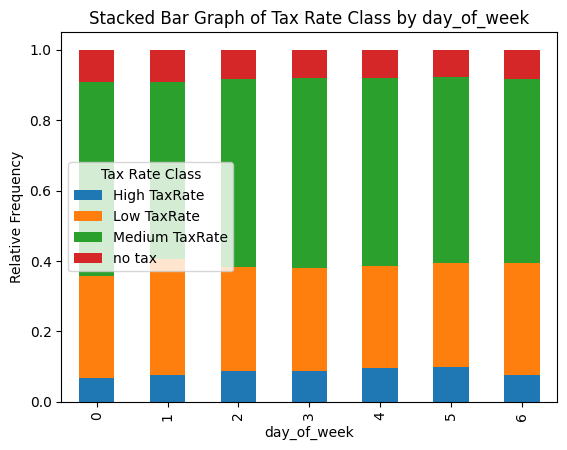

In [23]:
plot_stacked_bars('day_of_week')

Upon analyzing the graph, it becomes evident that there is a noticeable correlation between the day of the month and the tax rate. Specifically, we observe that the low tax rate tends to increase on the days {28, 29, 30, 1, 2, 3}, while the medium tax rate shows an upward trend on the days {5, 6, 7}.
Hence, I will keep this attribut.

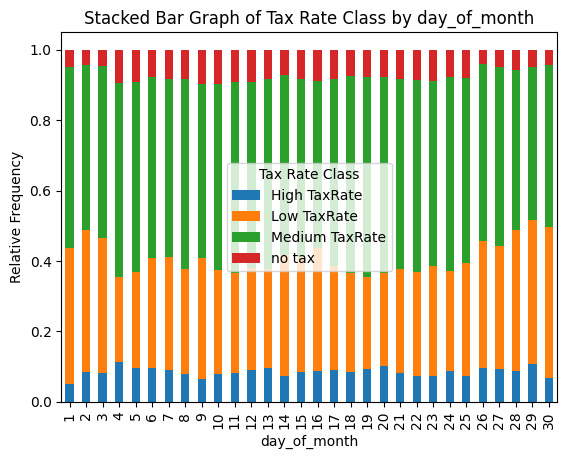

In [24]:
plot_stacked_bars('day_of_month')

There exists a significant correlation between the hour of the day and the tax rate class. This correlation is explicitly demonstrated through the graph, indicating a clear relationship between these two variables. 

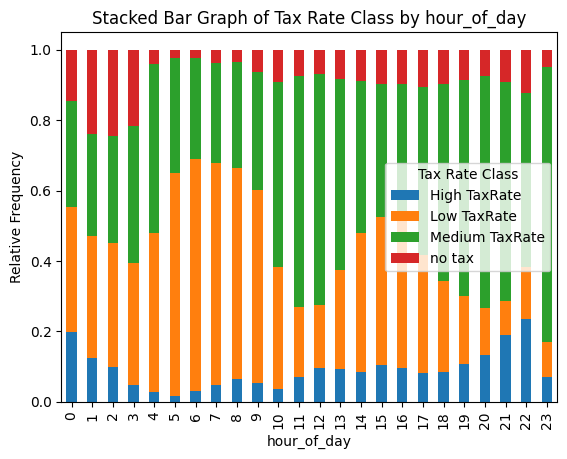

In [25]:
plot_stacked_bars('hour_of_day')

#### Scaling the `amount` column and resolving the **skewness** problem:

In [26]:
df0 = df.sample(n=100000, random_state=42).copy()

In [27]:
# Group the data by 'taxRateClass' and calculate the statistical measures
grouped_data = df0.groupby('taxRateClass')['amount'].agg(['mean', 'median', 'max', 'min',  'std'])

# Rename the columns for better representation
grouped_data.columns = ['Mean', 'Median', 'Max', 'Min', 'Standard Deviation']

# Calculate the skewness of the column
skewness = round(df0['amount'].skew(), 2)

# Print the skewness value
print("Skewness:", skewness)

# Display the table
print(grouped_data)

Skewness: 56.51
                     Mean  Median      Max  Min  Standard Deviation
taxRateClass                                                       
High TaxRate     9.368563     5.5    895.0  0.0           21.238078
Low TaxRate      8.664594     3.2  15500.0  0.0          163.195830
Medium TaxRate   7.170483     5.0   1420.5  0.0           13.603640
no tax          98.155456     1.4  32000.0  0.0          924.132200


In [28]:

# Create a RobustScaler object
scaler = RobustScaler()

# Fit the scaler to the 'amount' column and transform the data
df0['amount'] = scaler.fit_transform(df0[['amount']])


In [29]:
df0 = df0[df0['amount'] >= 0]

# Adding a small constant value to handle zero values
epsilon = 1e-6
df0['amount'] = boxcox(df0['amount'] + epsilon)[0]

In [30]:
# Group the data by 'taxRateClass' and calculate the statistical measures
grouped_data = df0.groupby('taxRateClass')['amount'].agg(['mean', 'median', 'max', 'min',  'std'])

# Rename the columns for better representation
grouped_data.columns = ['Mean', 'Median', 'Max', 'Min', 'Standard Deviation']

# Calculate the skewness of the column
skewness = round(df0['amount'].skew(), 2)

# Print the skewness value
print("Skewness:", skewness)

# Display the table
print(grouped_data)


Skewness: 0.1
                    Mean    Median        Max        Min  Standard Deviation
taxRateClass                                                                
High TaxRate   -0.809870 -0.850460   5.350960  -5.669860            1.373808
Low TaxRate    -0.737736 -0.649354   9.223367 -10.029919            1.440679
Medium TaxRate -0.599773 -0.310714   5.943285 -10.029919            1.184781
no tax          0.608732  0.281129  10.295899  -3.637509            1.906683


## **Training and Evaluation**

### **``Prepare Data For training:``**

#### Select the attributs: 

In [31]:
selected_features = ['amount', 
                     'itemName', 
                     'type', 
                     'storeId', 
                     'taxRateClass',
                     'hour_of_day',
                    #  'day_of_week', 
                     'day_of_month', 
                     ]
dff = df0[selected_features]

####  Calculate Word Counts using CountVectorizer: 

In [32]:
# CountVectorizer() converts a collection 
# of text documents to a matrix of token counts
vectorizer = CountVectorizer()
# assign a shorter name for the analyze
# which tokenizes the string
analyzer = vectorizer.build_analyzer()

def wordcounts(s):
    c = {}
    # tokenize the string and continue, if it is not empty
    if analyzer(s):
        d = {}
        # find counts of the vocabularies and transform to array 
        w = vectorizer.fit_transform([s]).toarray()
        # vocabulary and index (index of w)
        vc = vectorizer.vocabulary_
        # items() transforms the dictionary's (word, index) tuple pairs
        for k,v in vc.items():
            d[v]=k # d -> index:word 
        for index,i in enumerate(w[0]):
            c[d[index]] = i # c -> word:count
    return  c

# add new column to the dataframe
dff['Word Counts'] = dff['itemName'].apply(wordcounts)
dff.head()

,amount,itemName,type,storeId,taxRateClass,hour_of_day,day_of_month,Word Counts
426730,-1.753993,chicken burger,0.0,392,Medium TaxRate,10,5,"{'burger': 1, 'chicken': 1}"
738732,0.851360,patisserie libre,0.0,383,Low TaxRate,16,6,"{'libre': 1, 'patisserie': 1}"
1706238,0.286097,the jucy lucy,0.0,1087,Medium TaxRate,18,13,"{'jucy': 1, 'lucy': 1, 'the': 1}"
1076714,0.713783,grand menu midi,1.0,516,Medium TaxRate,11,9,"{'grand': 1, 'menu': 1, 'midi': 1}"
2280997,-0.062883,winter boeuf,0.0,185,Low TaxRate,11,19,"{'boeuf': 1, 'winter': 1}"


#### Split Data into train Dataset, test Dataset:

In [33]:
dff = pd.get_dummies(dff, columns=['type'])


In [34]:
train_data,test_data = train_test_split(dff,train_size=0.8,random_state=0)
X_train=train_data.drop(['taxRateClass'], axis=1)
y_train=train_data['taxRateClass']
X_test=test_data.drop(['taxRateClass'], axis=1)
y_test=test_data['taxRateClass']

In [35]:
# train_data,test_data = train_test_split(dff,train_size=0.8,random_state=0)
# select the columns and 
# prepare data for the models 
X_train = vectorizer.fit_transform(X_train['itemName'])
# y_train = train_data['taxRateClass']
X_test = vectorizer.transform(X_test['itemName'])
y_test = test_data['taxRateClass']

### **``Model training and evaluation:``**

In [36]:
def evaluate(model):
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test) 
    prob = model.predict_proba(X_test)
    fpr = {}
    tpr = {}
    thresh ={}
    for i in range(4):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob[:,i], pos_label=i)
    #printing the model name and accuracy !!!!!
    print("Model name:---->>>",model)
    print("accuracy score:--->>",accuracy_score(y_test,y_pred))
    print("Overall Precision:--->>",precision_score(y_test, y_pred, average='macro'))
    print("Overall Recall:--->>",recall_score(y_test, y_pred, average='macro'))
    print('Average AUC:--->>', roc_auc_score(y_test,prob, multi_class='ovr'))
    
    print("\n")
    print(classification_report(y_test,y_pred))
    print("<<<<-------------------------------------------------------------------->>>>")

In [37]:
LR=LogisticRegression(C=10, penalty='l2', solver="newton-cg") #Logistic regression.
knn=KNeighborsClassifier(metric='manhattan',n_neighbors=1,weights='uniform') 
svc=SVC(C=1,gamma=1,kernel='rbf',random_state=42) # support vector classifier.
dtc=DecisionTreeClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 2)
rf=RandomForestClassifier(random_state=42) #random forest classifier.
xgb=XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', learning_rate=1,n_estimators=700,random_state=42) #extream gradient boosting classifier.
gbr=GradientBoostingClassifier(learning_rate= 1,n_estimators=500,criterion='mse',random_state=42)


##### **Support Vector Classifier:**

I encountered a challenge when training the SVC model on a high-scale dataset. The training process took an impractical amount of time for a dataset with a length of 3 million.

Training the SVC model on 100,000 random samples from the original dataset already took 2 minutes. This indicates that training on the full dataset is impossible due to time constraints.



In [38]:
model=svc
model.fit(X_train,y_train)
y_pred=model.predict(X_test) 
# prob = model.predict_proba(X_test)
# fpr = {}
# tpr = {}
# thresh ={}
# for i in range(4):    
#     fpr[i], tpr[i], thresh[i] = roc_curve(y_test, prob[:,i], pos_label=i)
#printing the model name and accuracy !!!!!
print("Model name:---->>>",model)
print("accuracy score:--->>",accuracy_score(y_test,y_pred))
print("Overall Precision:--->>",precision_score(y_test, y_pred, average='macro'))
print("Overall Recall:--->>",recall_score(y_test, y_pred, average='macro'))
# print('Average AUC:--->>', roc_auc_score(y_test,prob, multi_class='ovr'))

print("\n")
print(classification_report(y_test,y_pred))
print("<<<<-------------------------------------------------------------------->>>>")

Model name:---->>> SVC(C=1, gamma=1, random_state=42)
accuracy score:--->> 0.8275344931013797
Overall Precision:--->> 0.8492723094719374
Overall Recall:--->> 0.7715837772910169


                precision    recall  f1-score   support

  High TaxRate       0.92      0.81      0.86      1061
   Low TaxRate       0.74      0.73      0.73      2360
Medium TaxRate       0.84      0.89      0.86      5980
        no tax       0.89      0.67      0.76       601

      accuracy                           0.83     10002
     macro avg       0.85      0.77      0.81     10002
  weighted avg       0.83      0.83      0.83     10002

<<<<-------------------------------------------------------------------->>>>


##### **Logistic Regression:**

Despite promising results, the logistic regression model falls short in terms of performance compared to the Decision Tree Classifier (DTC), even after fine-tuning. While logistic regression may have certain advantages, such as interpretability and simplicity, it may not capture the underlying complexity of the dataset as effectively as the DTC. 

In [39]:
# C=10, penalty='l2', solver="newton-cg"
%time evaluate(LR)

Model name:---->>> LogisticRegression(C=10, solver='newton-cg')
accuracy score:--->> 0.8170365926814637
Overall Precision:--->> 0.8071702356926875
Overall Recall:--->> 0.7711368469429993
Average AUC:--->> 0.94214218659656


                precision    recall  f1-score   support

  High TaxRate       0.90      0.87      0.89      1061
   Low TaxRate       0.70      0.74      0.72      2360
Medium TaxRate       0.85      0.86      0.86      5980
        no tax       0.77      0.62      0.68       601

      accuracy                           0.82     10002
     macro avg       0.81      0.77      0.79     10002
  weighted avg       0.82      0.82      0.82     10002

<<<<-------------------------------------------------------------------->>>>
CPU times: total: 5.39 s
Wall time: 5.75 s


In [40]:
model = LogisticRegression()
param_grid = {
    'C': [0.1, 1.0, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.8115786045364674


##### **K-Nearest Neighbors:**


The KNN model was not applicable to a high-scale dataset due to limitations in available memory.

In [41]:
# This cell should be run when the number the samples does not exceed 300,000

%time evaluate(knn)

Model name:---->>> KNeighborsClassifier(metric='manhattan', n_neighbors=1)
accuracy score:--->> 0.7965406918616277
Overall Precision:--->> 0.7804002749032539
Overall Recall:--->> 0.768821750771177
Average AUC:--->> 0.8359899761150773


                precision    recall  f1-score   support

  High TaxRate       0.91      0.83      0.87      1061
   Low TaxRate       0.70      0.64      0.67      2360
Medium TaxRate       0.83      0.86      0.84      5980
        no tax       0.69      0.75      0.72       601

      accuracy                           0.80     10002
     macro avg       0.78      0.77      0.77     10002
  weighted avg       0.80      0.80      0.80     10002

<<<<-------------------------------------------------------------------->>>>
CPU times: total: 40.7 s
Wall time: 10.3 s


##### ***Decision Tree Classifier***

Among the models evaluated, the Decision Tree Classifier (DTC) stands out as the most favorable option. It exhibits remarkable performance with a training time of under 2.5 seconds, when handling a dataset consisting of 100,000 samples. Furthermore, the DTC achieves the highest accuracy recorded thus far, reaching an impressive 83.4%. Additionally, the average Area Under the Curve (AUC) value stands at an encouraging 0.93, further demonstrating the model's effectiveness in classification tasks. The combination of fast training time, high accuracy, and strong AUC performance solidifies the DTC as the best model identified thus far in this project.






In [42]:
%time evaluate(dtc)

Model name:---->>> DecisionTreeClassifier()
accuracy score:--->> 0.8341331733653269
Overall Precision:--->> 0.8275603792149722
Overall Recall:--->> 0.8058670270716364
Average AUC:--->> 0.9291582476696412


                precision    recall  f1-score   support

  High TaxRate       0.89      0.88      0.88      1061
   Low TaxRate       0.71      0.79      0.75      2360
Medium TaxRate       0.88      0.86      0.87      5980
        no tax       0.83      0.70      0.76       601

      accuracy                           0.83     10002
     macro avg       0.83      0.81      0.81     10002
  weighted avg       0.84      0.83      0.84     10002

<<<<-------------------------------------------------------------------->>>>
CPU times: total: 1.88 s
Wall time: 1.89 s


In [43]:
model = DecisionTreeClassifier()
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10, 50 ],
    'min_samples_leaf': [1, 2, 3]
}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.8262012424652866


##### **eXtreme Gradient Boosting:**

The XGB model, known for its popularity in Kaggle competitions, demonstrates a training time of 9.3 seconds. However, due to the substantial size of our dataset, it becomes challenging to determine the best hyperparameters for optimal performance. The computational demands posed by the large data make it regrettably impossible to extensively explore and fine-tune the hyperparameters of the XGB model.




In [44]:
%time evaluate(xgb)

Model name:---->>> XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=700, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)
accuracy score:--->> 0.8249350129974006
Overall Precision:--->> 0.8362941076753934
Overall Recall:--->> 0.768433603655963
Average AUC:--->> 0.9464715434610604


                precision    recall  f1-score   support

  High TaxRate       0.89      0.84      0.86      1061
   Low Ta

In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Create an instance of the XGBClassifier
xgb_model = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss')

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [1, 2],
    'n_estimators': [500, 700],
    'max_depth': [5, 7]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'learning_rate': 1, 'max_depth': 7, 'n_estimators': 700}
Best Score: 0.8170026984567444


##### **Gradient Boosting Classifier:**

Similar to the XGB model, this model also faces the same limitations when it comes to training the entire dataset. Due to the size and complexity of the dataset, it is impractical and impossible to train the model on the complete dataset.

In [46]:
%time evaluate(gbr)

Model name:---->>> GradientBoostingClassifier(criterion='mse', learning_rate=1, n_estimators=500,
                           random_state=42)
accuracy score:--->> 0.7623475304939012
Overall Precision:--->> 0.7888636668231117
Overall Recall:--->> 0.6268735514543137
Average AUC:--->> 0.8348733561572403


                precision    recall  f1-score   support

  High TaxRate       0.86      0.71      0.78      1061
   Low TaxRate       0.71      0.55      0.62      2360
Medium TaxRate       0.76      0.90      0.82      5980
        no tax       0.83      0.35      0.49       601

      accuracy                           0.76     10002
     macro avg       0.79      0.63      0.68     10002
  weighted avg       0.76      0.76      0.75     10002

<<<<-------------------------------------------------------------------->>>>
CPU times: total: 26.4 s
Wall time: 26.5 s


##### **Conclusion:**

Based on the previous comparison and analysis, we can confidently conclude that the Decision Tree Classifier (DTC) is the optimal model for our classification problem. The DTC consistently demonstrated the best performance across various metrics, including accuracy and training time. With an impressive accuracy score, it proves to be highly effective in capturing the underlying patterns within the dataset. Furthermore, the scalability of the DTC is noteworthy, as it exhibits reasonable training times even with larger datasets. These combined factors make the DTC the most suitable choice for our classification problem, ensuring both high performance and efficient scalability.






## **OUR MODEL:**

In [47]:
# Group the data by 'taxRateClass' and calculate the statistical measures
grouped_data = df.groupby('taxRateClass')['amount'].agg(['mean', 'median', 'max', 'min',  'std'])

# Rename the columns for better representation
grouped_data.columns = ['Mean', 'Median', 'Max', 'Min', 'Standard Deviation']

# Calculate the skewness of the column
skewness = round(df['amount'].skew(), 2)

# Print the skewness value
print("Skewness:", skewness)

# Display the table
print(grouped_data)

Skewness: 263.56
                      Mean  Median       Max  Min  Standard Deviation
taxRateClass                                                         
High TaxRate      9.303224    5.20   12000.0  0.0           54.339315
Low TaxRate       9.748050    3.15  333333.0  0.0          441.059945
Medium TaxRate    7.282431    5.00   99999.0  0.0           81.219434
no tax          104.456326    1.40   85000.0  0.0         1059.628983


In [48]:
# Create a RobustScaler object
scaler = RobustScaler()

# Fit the scaler to the 'amount' column and transform the data
df['amount'] = scaler.fit_transform(df[['amount']])

df = df[df['amount'] >= 0]

# Adding a small constant value to handle zero values
epsilon = 1e-6
df['amount'] = boxcox(df['amount'] + epsilon)[0]

# Group the data by 'taxRateClass' and calculate the statistical measures
grouped_data = df0.groupby('taxRateClass')['amount'].agg(['mean', 'median', 'max', 'min',  'std'])

# Rename the columns for better representation
grouped_data.columns = ['Mean', 'Median', 'Max', 'Min', 'Standard Deviation']

# Calculate the skewness of the column
skewness = round(df0['amount'].skew(), 2)

# Print the skewness value
print("Skewness:",skewness)

# Display the table
print(grouped_data)

Skewness: 0.1
                    Mean    Median        Max        Min  Standard Deviation
taxRateClass                                                                
High TaxRate   -0.809870 -0.850460   5.350960  -5.669860            1.373808
Low TaxRate    -0.737736 -0.649354   9.223367 -10.029919            1.440679
Medium TaxRate -0.599773 -0.310714   5.943285 -10.029919            1.184781
no tax          0.608732  0.281129  10.295899  -3.637509            1.906683


In [49]:
selected_features = ['amount', 
                     'itemName', 
                    #  'type', 
                    #  'storeId', 
                     'taxRateClass',
                    #  'hour_of_day',
                    #  'day_of_week', 
                    #  'day_of_month', 
                     ]
dff = df[selected_features]

In [50]:
# CountVectorizer() converts a collection 
# of text documents to a matrix of token counts
vectorizer = CountVectorizer()
# assign a shorter name for the analyze
# which tokenizes the string
analyzer = vectorizer.build_analyzer()

def wordcounts(s):
    c = {}
    # tokenize the string and continue, if it is not empty
    if analyzer(s):
        d = {}
        # find counts of the vocabularies and transform to array 
        w = vectorizer.fit_transform([s]).toarray()
        # vocabulary and index (index of w)
        vc = vectorizer.vocabulary_
        # items() transforms the dictionary's (word, index) tuple pairs
        for k,v in vc.items():
            d[v]=k # d -> index:word 
        for index,i in enumerate(w[0]):
            c[d[index]] = i # c -> word:count
    return  c

# add new column to the dataframe
dff['Word Counts'] = dff['itemName'].apply(wordcounts)
dff.head()

,amount,itemName,taxRateClass,Word Counts
1,0.239226,formule boeuf 🥙🍟🥤,no tax,"{'boeuf': 1, 'formule': 1}"
2,-0.542279,pita boeuf,Medium TaxRate,"{'boeuf': 1, 'pita': 1}"
5,-0.472115,divers tva 5.5%,Low TaxRate,"{'divers': 1, 'tva': 1}"
7,-0.807979,"50cl ipa ""la félicité"" - pression",High TaxRate,"{'50cl': 1, 'félicité': 1, 'ipa': 1, 'la': 1, ..."
8,0.872765,côté california,Low TaxRate,"{'california': 1, 'côté': 1}"


In [51]:
# dff = pd.get_dummies(dff, columns=['type'])

train_data,test_data = train_test_split(dff,train_size=0.8,random_state=0)
X_train=train_data.drop(['taxRateClass'], axis=1)
y_train=train_data['taxRateClass']
X_test=test_data.drop(['taxRateClass'], axis=1)
y_test=test_data['taxRateClass']

# train_data,test_data = train_test_split(dff,train_size=0.8,random_state=0)
# select the columns and 
# prepare data for the models 
X_train = vectorizer.fit_transform(X_train['itemName'])
# y_train = train_data['taxRateClass']
X_test = vectorizer.transform(X_test['itemName'])
y_test = test_data['taxRateClass']

In [55]:
final_dtc=DecisionTreeClassifier(max_depth= None, min_samples_leaf= 1, min_samples_split= 2)
evaluate(final_dtc)

Model name:---->>> DecisionTreeClassifier()
accuracy score:--->> 0.8888304795442382
Overall Precision:--->> 0.8956854461654601
Overall Recall:--->> 0.87547948209818
Average AUC:--->> 0.9803205781581804


                precision    recall  f1-score   support

  High TaxRate       0.96      0.97      0.96     33839
   Low TaxRate       0.78      0.88      0.82     75349
Medium TaxRate       0.93      0.89      0.91    186849
        no tax       0.92      0.76      0.83     19742

      accuracy                           0.89    315779
     macro avg       0.90      0.88      0.88    315779
  weighted avg       0.89      0.89      0.89    315779

<<<<-------------------------------------------------------------------->>>>


## **The Function:**

In [56]:
import pickle
import random 

# After training your Decision Tree Classifier
# Save the model
with open('final_dtc.pkl', 'wb') as f:
    pickle.dump(final_dtc, f)

# Save the vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
    
# save teh scaler
with open("scaler.pkl", "wb") as file:
    pickle.dump(scaler, file)

In [57]:
# Load the trained model and vectorizer
with open('final_dtc.pkl', 'rb') as f:
    final_dtc = pickle.load(f)

with open('vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

# Load the scaler object from the pickle file
with open("scaler.pkl", "rb") as file:
    scaler = pickle.load(file)

In [58]:
vectorizer

CountVectorizer()

In [59]:
def predict_tax_rate_class(itemName, amount):
    # Construct a dataframe from the inputs
    data = {
        'itemName': [itemName],
        'amount': [amount]
    }
    new_data = pd.DataFrame(data)

    new_data['amount'] = scaler.transform(new_data[['amount']])

    # Vectorize 'itemName' using CountVectorizer
    # Here I am assuming you have loaded the trained vectorizer into a variable named 'vectorizer'
    itemName_transformed = vectorizer.transform(new_data['itemName']).toarray()
    df_itemName = pd.DataFrame(itemName_transformed, columns=vectorizer.get_feature_names())
    new_data = pd.concat([new_data, df_itemName], axis=1)
    new_data = new_data.drop(columns=['itemName', '00'])  # Drop the original 'itemName' column



    # print(new_data.iloc[0])

    # Making prediction
    prediction = final_dtc.predict(new_data)

    return prediction[0]


In [60]:
predict_tax_rate_class(itemName= "menu étudiant", amount=8)


'no tax'